In [1]:
import numpy as np
import tensorflow as tf
from keras import layers, models, optimizers
from keras.callbacks import TensorBoard

In [2]:
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
x_train = (x_train - 127.5) / 127.5

In [3]:
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 128, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

In [4]:
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [5]:
class GAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Train discriminator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        generated_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            all_images = tf.concat([generated_images, real_images], axis=0)
            labels = tf.concat([generated_labels, tf.ones((batch_size, 1))], axis=0)
            preds = self.discriminator(all_images)
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            preds = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, preds)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}

In [6]:
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [7]:
gan.compile(d_optimizer=optimizers.Adam(learning_rate=0.0002),
            g_optimizer=optimizers.Adam(learning_rate=0.0002),
            loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True))

In [8]:
tensorboard_callback = TensorBoard(log_dir="./log", histogram_freq=1)

In [11]:
gan.fit(x_train, batch_size=128, epochs=10,callbacks=[tensorboard_callback])

Epoch 1/10
469/469 [==============================] - 207s 441ms/step - d_loss: 0.3770 - g_loss: 2.3175
Epoch 2/10
469/469 [==============================] - 211s 449ms/step - d_loss: 0.4080 - g_loss: 2.0066
Epoch 3/10
469/469 [==============================] - 268s 571ms/step - d_loss: 0.4362 - g_loss: 2.0774
Epoch 4/10
469/469 [==============================] - 277s 590ms/step - d_loss: 0.4144 - g_loss: 1.8546
Epoch 5/10
469/469 [==============================] - 246s 525ms/step - d_loss: 0.4085 - g_loss: 1.8862
Epoch 6/10
469/469 [==============================] - 240s 511ms/step - d_loss: 0.3326 - g_loss: 2.0227
Epoch 7/10
469/469 [==============================] - 237s 506ms/step - d_loss: 0.3247 - g_loss: 2.1913
Epoch 8/10
469/469 [==============================] - 210s 449ms/step - d_loss: 0.2794 - g_loss: 2.4026
Epoch 9/10
469/469 [==============================] - 249s 532ms/step - d_loss: 0.2562 - g_loss: 2.4372
Epoch 10/10
469/469 [==============================] - 256s 546m

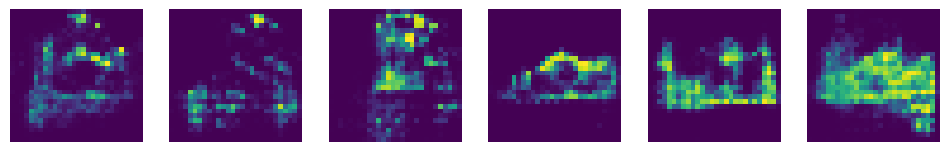

In [12]:
import matplotlib.pyplot as plt
def generate_and_plot_images(generator, latent_dim, num_images=6):
    random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))
    generated_images = generator(random_latent_vectors)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axes[i].imshow((generated_images[i] * 127.5 + 127.5).numpy().astype(np.uint8))
        axes[i].axis('off')
    plt.show()

generate_and_plot_images(generator, latent_dim)